In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tqdm import tqdm
import numpy as np
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


Using device: cuda


In [31]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Get MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform
)

# Create data loaders
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Dataset info
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size:     {len(test_dataset)}")
print(f"Number of batches in training: {len(train_loader)}")
print(f"Number of batches in testing:  {len(test_loader)}")


Training dataset size: 60000
Test dataset size:     10000
Number of batches in training: 938
Number of batches in testing:  157


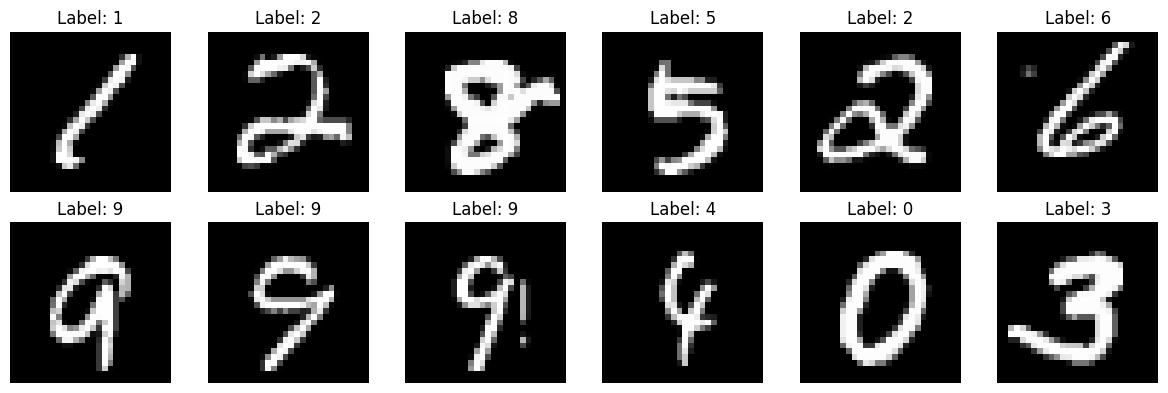

In [32]:
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1)
    img = images[i].squeeze()
    img = img * 0.3081 + 0.1307
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {labels[i].item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()


In [33]:
class CNN(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(CNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.fc_block = nn.Sequential(
            nn.Dropout(dropout_prob),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = torch.flatten(x, 1)
        x = self.fc_block(x)
        return x

    def extract_flatten_features(self, x):
        x = self.conv_block(x)
        x = torch.flatten(x, 1)
        return x

model = CNN().to(device)
print(model)


CNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_block): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [35]:
num_epochs = 5
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    correct_train, total_train, running_train_loss = 0, 0, 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_train_acc = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    model.eval()
    correct_test, total_test, running_test_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    epoch_test_loss = running_test_loss / len(test_loader)
    epoch_test_acc = 100 * correct_test / total_test
    test_losses.append(epoch_test_loss)
    test_accuracies.append(epoch_test_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% | "
          f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.2f}%")


Epoch 1/5 [Train]: 100%|██████████| 938/938 [00:17<00:00, 54.68it/s]


Epoch 1/5 | Train Loss: 0.1419, Train Acc: 95.55% | Test Loss: 0.0514, Test Acc: 98.33%


Epoch 2/5 [Train]: 100%|██████████| 938/938 [00:16<00:00, 57.54it/s]


Epoch 2/5 | Train Loss: 0.0628, Train Acc: 98.02% | Test Loss: 0.0361, Test Acc: 98.82%


Epoch 3/5 [Train]: 100%|██████████| 938/938 [00:17<00:00, 55.08it/s]


Epoch 3/5 | Train Loss: 0.0488, Train Acc: 98.43% | Test Loss: 0.0425, Test Acc: 98.66%


Epoch 4/5 [Train]: 100%|██████████| 938/938 [00:16<00:00, 57.48it/s]


Epoch 4/5 | Train Loss: 0.0411, Train Acc: 98.70% | Test Loss: 0.0260, Test Acc: 99.10%


Epoch 5/5 [Train]: 100%|██████████| 938/938 [00:17<00:00, 55.13it/s]


Epoch 5/5 | Train Loss: 0.0355, Train Acc: 98.87% | Test Loss: 0.0273, Test Acc: 99.17%


In [36]:
model.eval()
with torch.no_grad():
    correct, total, running_loss = 0, 0, 0.0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = running_loss / len(test_loader)
test_acc = 100 * correct / total
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")
cnn_test_accuracy = test_acc


Test Loss: 0.0273 | Test Accuracy: 99.17%


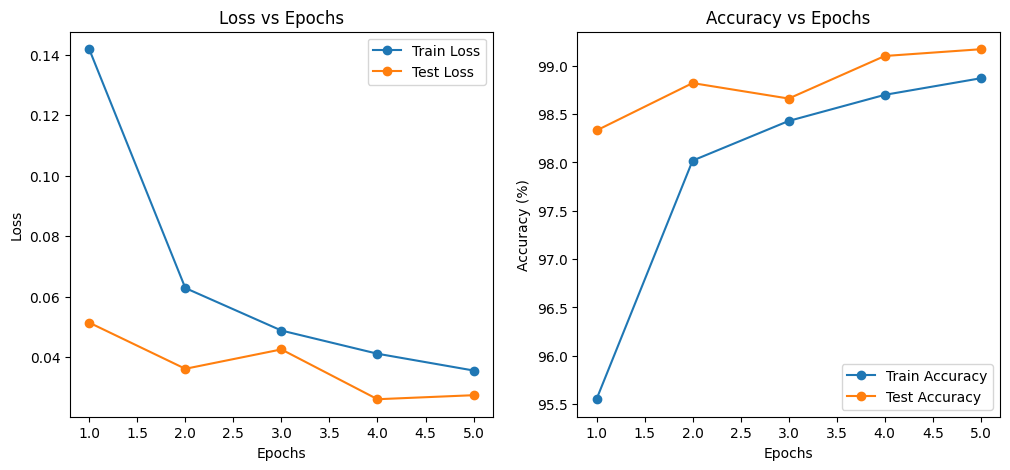

In [37]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, marker='o', label='Test Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), train_accuracies, marker='o', label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, marker='o', label='Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epochs")
plt.legend()
plt.show()


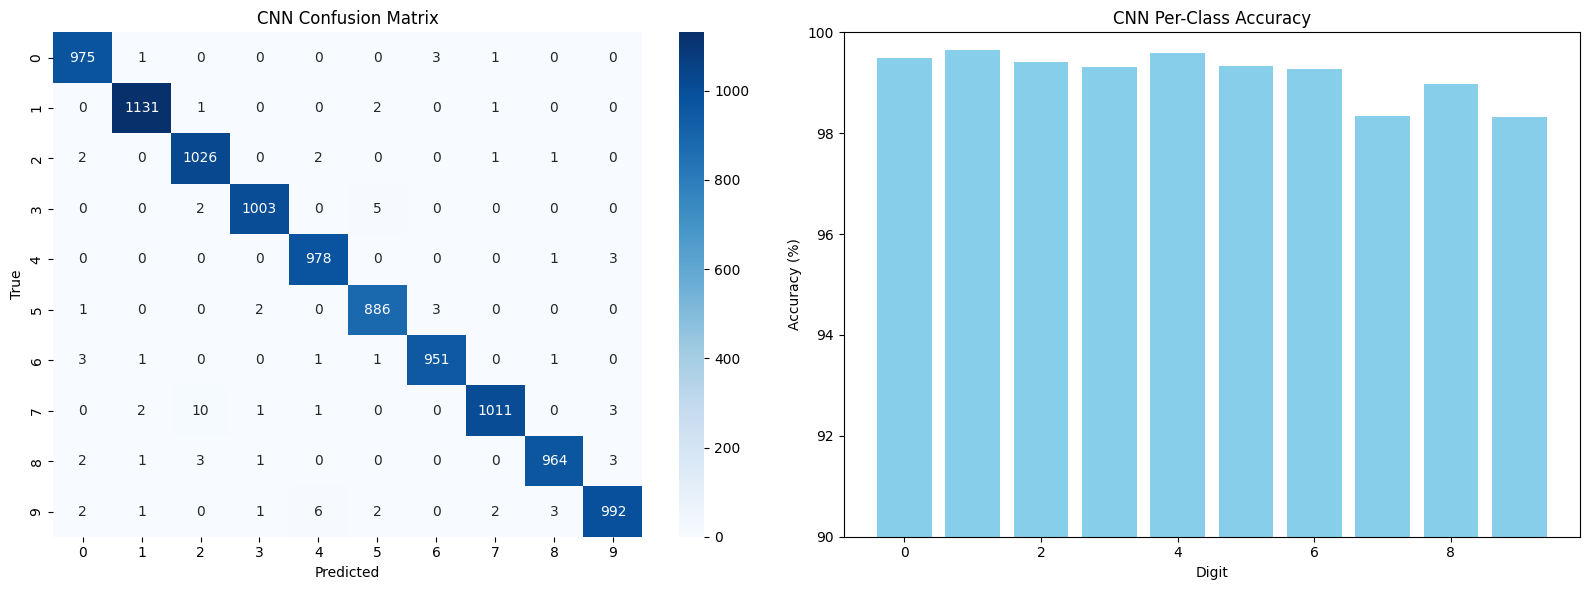

In [38]:
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
class_accuracy = cm.diagonal() / cm.sum(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(16,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
axes[0].set_title("CNN Confusion Matrix")

axes[1].bar(range(10), class_accuracy*100, color='skyblue')
axes[1].set_xlabel("Digit")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("CNN Per-Class Accuracy")
axes[1].set_ylim(90,100)
plt.tight_layout()
plt.show()


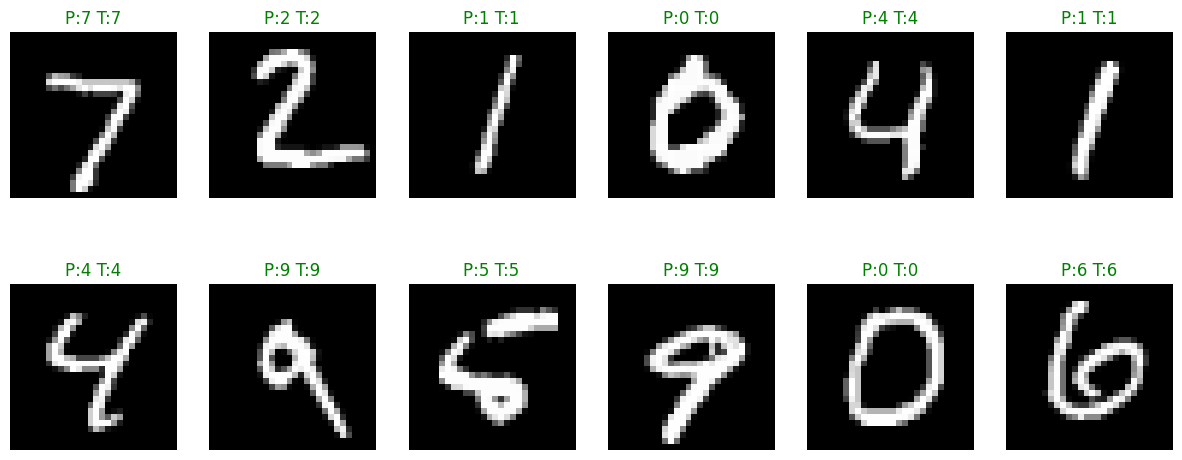

In [39]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

model.eval()
with torch.no_grad():
    output = model(example_data.to(device))
pred = output.argmax(dim=1, keepdim=True).cpu().numpy()

plt.figure(figsize=(15,6))
for i in range(12):
    plt.subplot(2,6,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
    color = 'green' if pred[i][0] == example_targets[i].item() else 'red'
    plt.title(f"P:{pred[i][0]} T:{example_targets[i].item()}", color=color)
    plt.axis('off')
plt.show()


In [40]:
# Freeze CNN
for p in model.parameters():
    p.requires_grad = False
model.eval()

def extract_features(dataloader, feature_fn):
    feats, labs = [], []
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Extracting features"):
            images = images.to(device)
            f = feature_fn(images).cpu().numpy()
            feats.append(f)
            labs.append(labels.numpy())
    return np.concatenate(feats), np.concatenate(labs)

X_train_all, y_train_all = extract_features(train_loader, model.extract_flatten_features)
X_test, y_test = extract_features(test_loader, model.extract_flatten_features)


Extracting features: 100%|██████████| 157/157 [00:02<00:00, 71.93it/s]


In [41]:
# Standardize features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_all)
X_test_std = scaler.transform(X_test)

In [42]:
# Subsample 15000 training samples for faster SVM training
subset_idx = np.random.choice(len(X_train_std), size=15000, replace=False)
X_train_sub, y_train_sub = X_train_std[subset_idx], y_train_all[subset_idx]

# Train RBF SVM
best_svm = SVC(C=1, gamma='scale', kernel='rbf')
best_svm.fit(X_train_sub, y_train_sub)


SVC(C=1)

In [43]:
svm_test_pred = best_svm.predict(X_test_std)
svm_test_acc = accuracy_score(y_test, svm_test_pred)*100
print(f"SVM Test Accuracy: {svm_test_acc:.2f}%")

SVM Test Accuracy: 98.11%


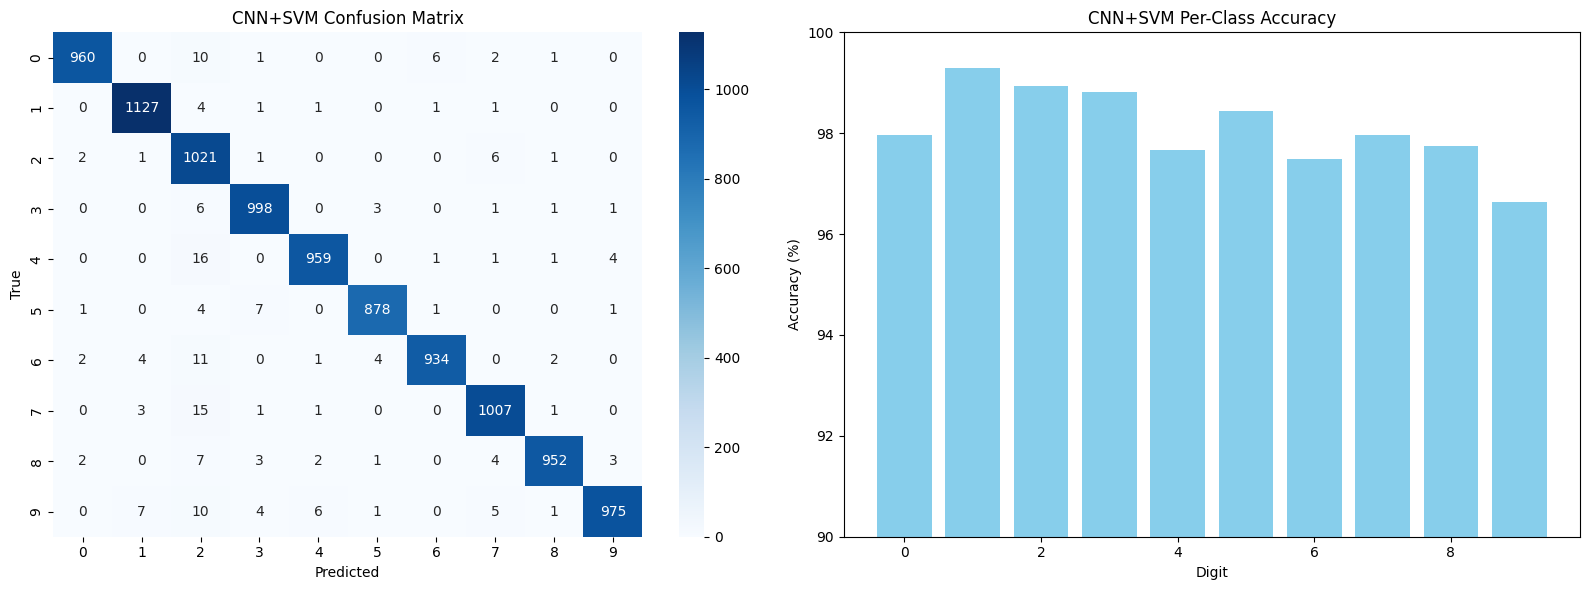

In [44]:
cm = confusion_matrix(y_test, svm_test_pred)
class_accuracy = cm.diagonal() / cm.sum(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
axes[0].set_title("CNN+SVM Confusion Matrix")

# Per-class accuracy
axes[1].bar(range(10), class_accuracy * 100, color='skyblue')
axes[1].set_xlabel("Digit")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("CNN+SVM Per-Class Accuracy")
axes[1].set_ylim(90, 100)

plt.tight_layout()
plt.show()


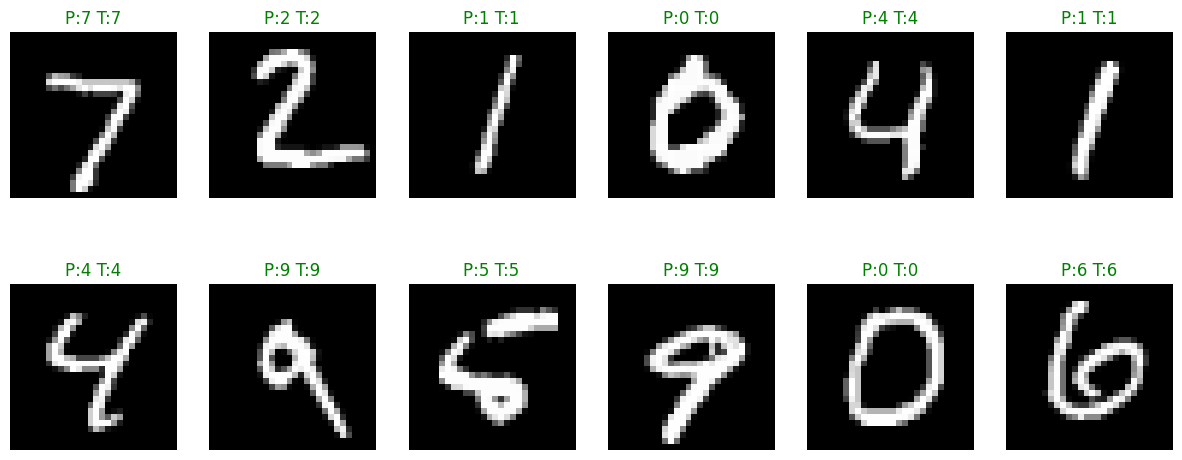

In [45]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

model.eval()
with torch.no_grad():
    features = model.extract_flatten_features(example_data.to(device)).cpu().numpy()

features_std = scaler.transform(features)
svm_pred = best_svm.predict(features_std)

plt.figure(figsize=(15,6))
for i in range(12):
    plt.subplot(2,6,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
    color = 'green' if svm_pred[i] == example_targets[i].item() else 'red'
    plt.title(f"P:{svm_pred[i]} T:{example_targets[i].item()}", color=color)
    plt.axis('off')
plt.show()
